In [52]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as D
import torchvision
from tqdm import tqdm_notebook
import torchvision.transforms as transforms
from torchvision.utils import save_image

import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

import pdb

%matplotlib inline

In [53]:
import warnings
warnings.filterwarnings('ignore')

## Loading the dataset

In [54]:
batch_size = 20

In [60]:
transform = transforms.Compose(
    [transforms.ToTensor()])

trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True, num_workers=2)

class_names = tuple(str(i) for i in range(10))

In [56]:
transform = transforms.Compose([transforms.ToTensor()])

trainset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

testset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True, num_workers=2)

class_names = tuple(str(i) for i in range(10))

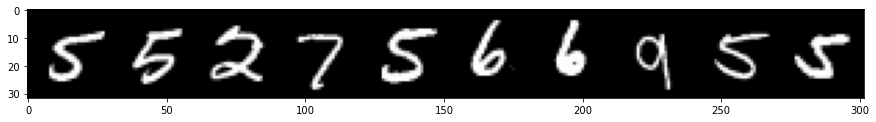

In [61]:
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

dataiter = iter(trainloader)
images, labels = dataiter.next()

plt.figure(figsize=(15,10))
imshow(torchvision.utils.make_grid(images[:10], nrow=10))
plt.show()

In [62]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"

In [63]:
device

'cuda:0'

## Model parameters

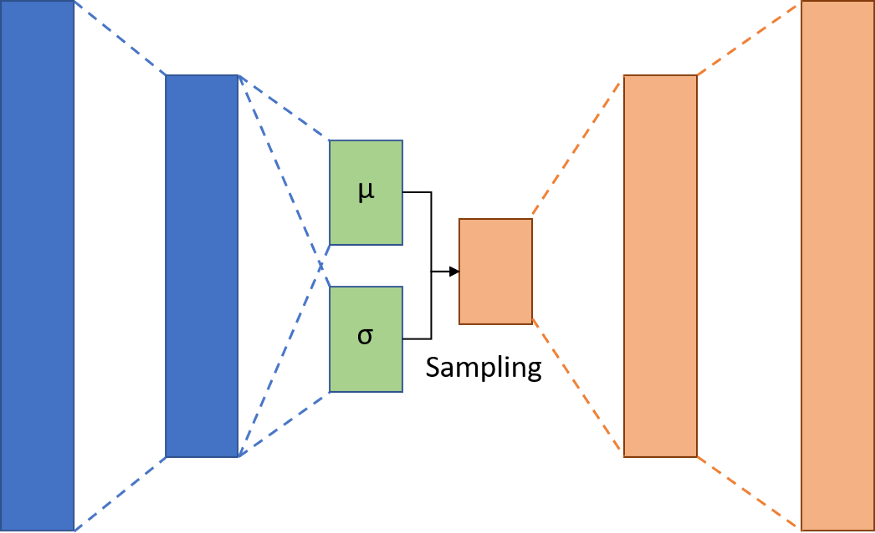

In [64]:
class VAE(nn.Module):
    def __init__(self, hidden_size):
        super(VAE, self).__init__()
        
        self.hidden_size = hidden_size
        self.encoder = nn.Sequential(nn.Linear(784,392),
                                     nn.ReLU())
        
        self.hidden_mu = nn.Linear(392, self.hidden_size)
        self.hidden_log_var = nn.Linear(392, self.hidden_size)
        
        self.decoder = nn.Sequential(nn.Linear(self.hidden_size, 392),
                                     nn.ReLU(),
                                     nn.Linear(392, 784),
                                     nn.Sigmoid())
        
    def encode(self, x):
        hidden = self.encoder(x)
        mu = self.hidden_mu(hidden)
        log_var = self.hidden_log_var(hidden)
        return mu, log_var

    def reparametrize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        z = torch.randn_like(std) # get normal distribution size of sigma
        return mu + z*std
    
    def decode(self, z):
        x = self.decoder(z)
        return x
    
    def forward(self, x):
        mu, log_var = self.encode(x.view(-1, 784))
        hidden = self.reparametrize(mu, log_var) # bottleneck
        output = self.decoder(hidden) # x_out
        return mu, log_var, output 

hidden_dim = 20
net = VAE(hidden_dim)

## Training

In [65]:
def loss_fn(mu, log_var, x_out, x):
        kl_loss = -0.5 * torch.sum( 1 + log_var - mu**2 - torch.exp(log_var))
        recon_loss = F.binary_cross_entropy(x_out, x.view(-1, 784), reduction='sum')
        loss = recon_loss + kl_loss
        return loss

optimizer = torch.optim.Adam(params = net.parameters())
#lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=100, gamma=0.75)
num_epochs = 13

In [66]:
train_loss=[]
test_loss = []
net.train(True)
for epoch in range(1, num_epochs+1):
    running_loss = 0
    for i, (data,_) in enumerate(tqdm_notebook(trainloader)):
        optimizer.zero_grad()
        mu, log_var, x_out = net(data)
    
        loss = loss_fn(mu, log_var, x_out, data)
        loss.backward()      
        running_loss += loss.detach().item()
        optimizer.step()
        if i%1000 == 0:
            train_loss.append(loss.detach().item()/len(batch))
    print('Epoch: {} Average loss: {:.4f}'.format(epoch, running_loss / len(trainloader.dataset)))
    
    with torch.no_grad():
        sample = torch.randn(64, hidden_dim)
        sample = net.decode(sample)
        save_image(sample.view(64, 1, 28, 28), 'vae_results/sample_' + str(epoch) + '.png')
    
    #net.train(False)
    #with torch.no_grad():
       # mu, log_var, x_out = net.forward(x)
       # test_loss.append(loss_fn(mu, log_var, x_out.reshape((batch_size,28,28)),x).item())

  0%|          | 0/3000 [00:00<?, ?it/s]

Epoch: 1 Average loss: 130.9499


  0%|          | 0/3000 [00:00<?, ?it/s]

Epoch: 2 Average loss: 112.4498


  0%|          | 0/3000 [00:00<?, ?it/s]

Epoch: 3 Average loss: 109.8028


  0%|          | 0/3000 [00:00<?, ?it/s]

Epoch: 4 Average loss: 108.5754


  0%|          | 0/3000 [00:00<?, ?it/s]

Epoch: 5 Average loss: 107.7376


  0%|          | 0/3000 [00:00<?, ?it/s]

Epoch: 6 Average loss: 107.1641


  0%|          | 0/3000 [00:00<?, ?it/s]

Epoch: 7 Average loss: 106.7101


  0%|          | 0/3000 [00:00<?, ?it/s]

Epoch: 8 Average loss: 106.2917


  0%|          | 0/3000 [00:00<?, ?it/s]

Epoch: 9 Average loss: 106.0216


  0%|          | 0/3000 [00:00<?, ?it/s]

Epoch: 10 Average loss: 105.6821


  0%|          | 0/3000 [00:00<?, ?it/s]

Epoch: 11 Average loss: 105.4273


  0%|          | 0/3000 [00:00<?, ?it/s]

Epoch: 12 Average loss: 105.1769


  0%|          | 0/3000 [00:00<?, ?it/s]

Epoch: 13 Average loss: 104.9761


## Testing

In [67]:
net.train(False)
for i, (data,_) in enumerate(tqdm_notebook(testloader)):    
    with torch.no_grad():
        mu, log_var, x_out = net.forward(data)
        loss = loss_fn(mu, log_var, x_out, data)
        if i%100 == 0:
            test_loss.append(loss.detach().item()/len(batch))

  0%|          | 0/500 [00:00<?, ?it/s]

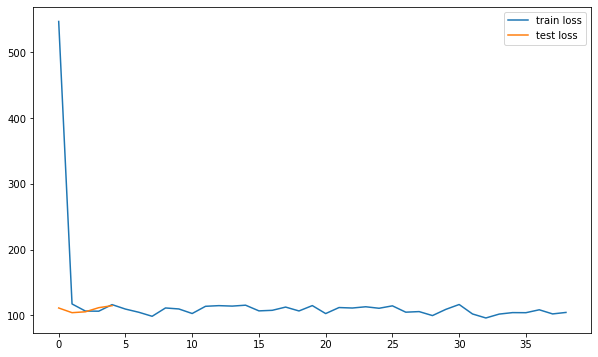

In [68]:
plt.figure(figsize=(10,6))
plt.plot(np.arange(len(train_loss)), train_loss, label="train loss")
plt.plot(np.arange(len(test_loss)), test_loss, label="test loss")
plt.legend()
plt.show()

In [69]:
sample = torch.randn(64, 20)
sample = net.decode(sample)
save_image(sample.view(64, 1, 28, 28), 'vae_results/sample' + '.png')